In [56]:
import boto3
from langchain_aws import ChatBedrock
from botocore.config import Config
import warnings
warnings.filterwarnings("ignore")

region = "us-west-2"
config = Config(
    region_name=region,
    signature_version = "v4",
    retries={
        "max_attempts":3,
        "mode" : "standard",
    }
)
bedrock_rt = boto3.client("bedrock-runtime", config=config)

model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

model_kwargs = {
    "max_tokens" : 4096,
    "temperature" : 0.0,
    "stop_sequences" : ["Human"],
}

llm = ChatBedrock(
    client = bedrock_rt,
    model_id = model_id,
    model_kwargs = model_kwargs,
)

In [58]:
import os
import getpass
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain_core.output_parsers import StrOutputParser

os.environ['TAVILY_API_KEY'] = getpass.getpass()
tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

In [57]:
from typing import TypedDict,Sequence,Annotated
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]
    

In [59]:
tools = [tavily_tool]
llm = llm.bind_tools(tools)

def agent(state):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages" : [response]}

In [65]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage,AIMessage
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

def researcher(state):
    messages = state['messages']
    last_message = messages[-1]

    parsed_tool_input = json.loads(last_message.additional_kwargs["tool_calls"])
    action = ToolInvocation(
        tool = parsed_tool_input["name"],
        tool_input = parsed_tool_input['args']['query']
    )

    response = tool_executor.invoke(action)
    function_message = FunctionMessage(
        content = str(response),
        name = action.tool,
    )
    return {
        "messages" : [function_message]
    }

In [66]:
def router(state):
    messages = state['messages']
    last_message = messages[-1]

    if "tool_calls" in last_message.additional_kwargs:
        return "continue"
    else: 
        return "end"

In [67]:
from langgraph.graph import StateGraph,START,END

workflow = StateGraph(AgentState)

workflow.add_node("Agent",agent)
workflow.add_node("Researcher",researcher)

workflow.add_conditional_edges("Agent", router , {
    "continue" : "Researcher",
    "end" : END
})

workflow.add_edge("Researcher","Agent")
workflow.set_entry_point("Agent")

app = workflow.compile()

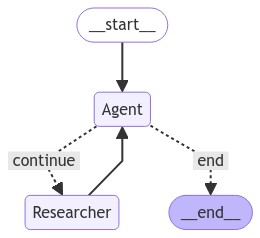

In [68]:
from IPython.display import Image,display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [69]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content = "What are the current weather conditions in Bengaluru?")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='What are the current weather conditions in Bengaluru?'),
  AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 274, 'completion_tokens': 62, 'total_tokens': 336}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 274, 'completion_tokens': 62, 'total_tokens': 336}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-415f496e-bc13-41b1-ab94-2b30383d8a14-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bengaluru weather'}, 'id': 'toolu_bdrk_01AUbXaTHdBgZzVHpEaGyjT2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 274, 'output_tokens': 62, 'total_tokens': 336})]}